In [1]:
# Reference: https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
from functools import partial
from tqdm import tqdm

tqdm = partial(tqdm, position=0, leave=True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay

data_dir = '/content/drive/My Drive/445_final_proj/face_detection'
# %cd /content/drive/MyDrive/Key-points-detection/
# from util import *
# from dataset import *
# %cd /content/

In [5]:
#!pip uninstall -y tensorflow


Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0


# Load Data

In [6]:
# Reference: https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/download_ibug_dataset.txt

%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [7]:
# This snippet of code is from https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/
# Exact location: https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/load_ibug_dataset.py

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
    img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
    box = filename[0].attrib
    # x, y for the top left corner of the box, w, h for box width and height
    bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

    landmark = []
    for num in range(68):
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
    landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32')

# Define training hyperparameters and functions

In [8]:
BATCH_SIZE = 64
EPOCH_SIZE = 100
lr = 5e-4
weight_decay = 1e-5
momentum = 0.9
TRAIN_VAL_SPLIT = 0.95
BATCH_INTERVAL = 150  # do a validation per BATCH_INTERVAL

In [9]:
transform = Compose([
    ResizeAndRandomRotate(15, size=(224, 224)),
    ToTensor()
])

NameError: ignored

In [ ]:
dataset = MyDataset('/content', img_filenames, landmarks, transform=transform)

train_data_size = int(len(dataset) * TRAIN_VAL_SPLIT)
val_data_size = len(dataset) - train_data_size

# Split trainning and validation dataset
train_set, val_set = torch.utils.data.random_split(dataset, lengths=(train_data_size, val_data_size))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=4)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
resnet = resnet18(num_classes=136)
resnet.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
resnet = resnet.to(device)

In [ ]:
import torch.nn.functional as F
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

from torchvision.models import inception_v3

resnet = inception_v3(num_classes=136, init_weights=True)
resnet.Conv2d_1a_3x3 = BasicConv2d(1, 32, kernel_size=3, stride=2)
resnet = resnet.to(device)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
l2_loss = nn.L1Loss().to(device) # This is actually L1 loss

In [ ]:
def criterion(output, target):
    target = target.to(device)
    return l2_loss(output, target)

In [ ]:
%matplotlib inline
def test():
    """
    Do a validation on current model
    """
    resnet.eval()
    val_loss = 0
    for batch_size, (image, anno) in enumerate(test_loader):
        image = image.to(device)
        out = resnet(image)
        val_loss += criterion(out, anno)
        if batch_size == 0:
            show_image(image, out)
    return val_loss

In [ ]:
import torch.nn.functional as F
def train(start_batch=0, state_dict=None):
    resnet.train()
    train_loss_hist = []
    test_loss_hist = []
    # if state_dict is not None:
        

    for i in range(EPOCH_SIZE):
        print(f'=======Epoch{i + 1}/{EPOCH_SIZE}==========')
        total_loss = 0
        for batch_i, (image, annotations) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            image = image.to(device)
            out = resnet(image)

            train_loss = criterion(out, annotations)
            train_loss.backward()
            optimizer.step()
            total_loss += float(train_loss)

            # calculate validation loss and save model
            # print(batch_i)
            if (batch_i + 1) % BATCH_INTERVAL == 0 or (batch_i + 1) == len(train_loader):
                resnet.eval()
                with torch.no_grad():
                    test_loss = test()
                    test_loss_hist.append(test_loss / val_data_size)
                    train_loss_hist.append(total_loss / train_data_size)
                    if not os.path.exists('model'):
                        os.mkdir('model')
                    torch.save(resnet.state_dict(), f'model/EPOCH_{i}_BATCH_{batch_i}.pth')
                print('========================================================================================')
                print(f'=========Train Loss is: {total_loss / train_data_size}==========Validation Loss is: {test_loss / val_data_size}')
                print('========================================================================================')
                resnet.train()

    plot_loss(train_loss_hist, test_loss_hist)

In [ ]:
train()

# Eval trained model

In [10]:
# !ls model/

In [11]:
# !rm -r model/

In [12]:
# !wget https://1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com/wp-content/uploads/shutterstock_149962697-946x658.jpg

In [13]:
# !wget https://ggia.berkeley.edu/assets/general/GGIA-HumanFace.jpg

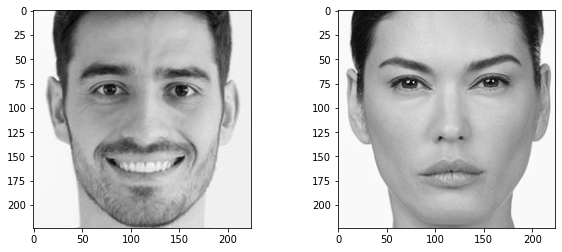

In [19]:

# Image must be first converted to grayscale and then resized to 224, 224. 
# For better result, you may need to manaully crop the image

# Ex: image = Image.open('GGIA-HumanFace.jpg').convert('L').crop((200, 0, 600, 430)).resize((224, 224))
# image.crop(box) box – a 4-tuple defining the left, upper, right, and lower pixel coordinate.

# image = Image.open('shutterstock_149962697-946x658.jpg').convert('L')
h, w = 224,224
image1 = Image.open(data_dir + '/ori_images/man1.jpg').resize((224, 224))
image1_gray = image1.convert('L')
image2 = Image.open(data_dir + '/ori_images/woman3.jpg').resize((224, 224))
image2_gray = image2.convert('L')

to_tensor = transforms.ToTensor()
tensor1 = to_tensor(image1_gray).unsqueeze(0)
tensor2 = to_tensor(image2_gray).unsqueeze(0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(image1_gray, cmap = 'gray')
axes[1].imshow(image2_gray, cmap = 'gray')



In [20]:
#!mv /content/model/EPOCH_48_BATCH_98.pth /content/drive/MyDrive/

In [21]:
# load data, look at the model folder for which model you want to use

epoch_number = 48  # modify this line
batch_number = 98  # modify this line

model_path = '/content/drive/My Drive/445_final_proj/face_detection/' + f'EPOCH_{epoch_number}_BATCH_{batch_number}.pth' # modify model path
# model_path = '/content/drive/My Drive/Key-points-detection/model/' + f'EPOCH_{epoch_number}_BATCH_{batch_number}.pth' 

In [22]:
def load_dict(model, path, eval=False):
    model = resnet18(num_classes=136)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.load_state_dict(torch.load(path))
    if eval:
        model.eval()
    return model

In [23]:
%%capture
model = resnet18(num_classes=136)
model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
model.load_state_dict(torch.load(model_path))
model.eval()

In [24]:
def show(image1,image2, anno1, anno2):
    anno1 = anno1.squeeze(0)
    anno2 = anno2.squeeze(0)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axes[0].imshow(image1)
    axes[0].scatter(anno1[:68], anno1[68:])
    axes[1].imshow(image2)
    axes[1].scatter(anno2[:68], anno2[68:])

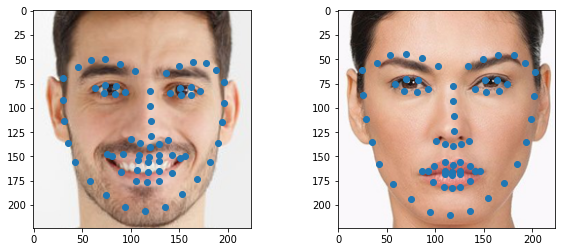

In [25]:
with torch.no_grad():
    out1 = model(tensor1)
    out2 = model(tensor2)
    show(image1,image2 ,out1, out2)

In [26]:
out1.shape

torch.Size([1, 136])

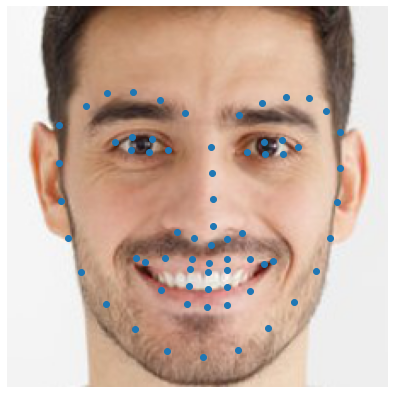

In [38]:
plt.figure(figsize= (7,7))
plt.imshow(image1)
plt.scatter(out1[0,:68],out1[0,68:])
plt.axis('off')
plt.show()

In [28]:
# pts1 = np.zeros((68,2))
# out1[0].shape
# # pts1[:,0] = out1[:68]
# # pts1[:,1] = out1[68:]
# # pts2 = np.float32((68,2))
# # pts2[:,0] = out2[:,68]
# # pts2[:,1] = out2[68,:]


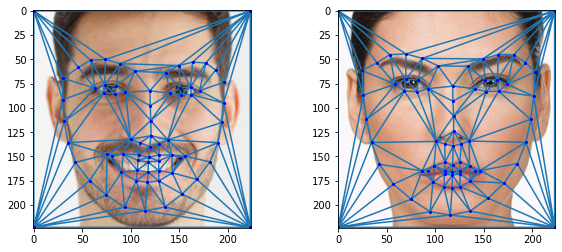

In [29]:
im1 = np.asarray(image1)
im2 = np.asarray(image2)

im1_pts = np.zeros((68,2)).astype(np.float32)
im1_pts[:,0] = out1[0, :68]
im1_pts[:,1] = out1[0, 68:]
im2_pts = np.zeros((68,2)).astype(np.float32)
im2_pts[:,0] = out2[0, :68]
im2_pts[:,1] = out2[0, 68:]
im1_pts = np.append(im1_pts, [[0,0],[0,h-1],[w-1,0],[w-1,h-1]], axis=0).astype(np.float32)
im2_pts = np.append(im2_pts, [[0,0],[0,h-1],[w-1,0],[w-1,h-1]], axis=0).astype(np.float32)
avg_pts = (im1_pts + im2_pts) / 2
tri = Delaunay(avg_pts)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(im1)
axes[0].triplot(im1_pts[:,0], im1_pts[:,1], tri.simplices)
axes[0].plot(im1_pts[:,0], im1_pts[:,1], 'o',c='b', markersize=2)
axes[1].imshow(im2)
axes[1].triplot(im2_pts[:,0], im2_pts[:,1], tri.simplices)
axes[1].plot(im2_pts[:,0], im2_pts[:,1], 'o',c='b', markersize=2)
plt.show()

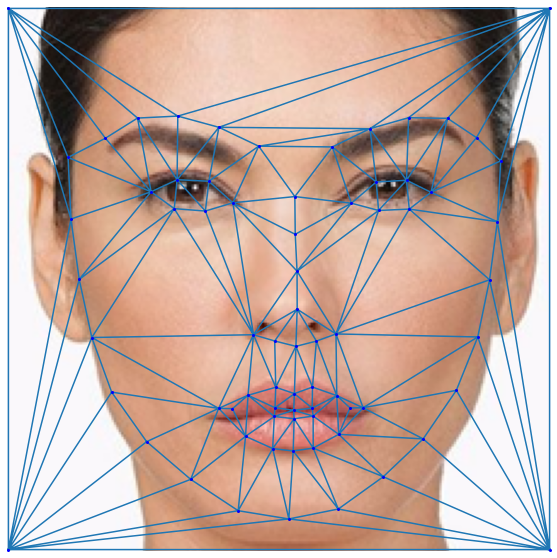

In [36]:
plt.figure(figsize=(15,10))
plt.imshow(im2)
plt.triplot(im2_pts[:,0], im2_pts[:,1], tri.simplices)
plt.plot(im2_pts[:,0], im2_pts[:,1], 'o',c='b', markersize=2)
plt.axis('off')
plt.show()

In [31]:
def getAffineInv(t1, t2, tavg):
    M1 = cv2.getAffineTransform(t1,tavg)
    M2 = cv2.getAffineTransform(t2,tavg)
    M1_squre = np.vstack([M1, [0,0,1]])
    M1_inv = np.delete(np.linalg.inv(M1_squre), 2, 0)
    M2_squre = np.vstack([M2, [0,0,1]])
    M2_inv = np.delete(np.linalg.inv(M2_squre), 2, 0)
    return (M1_inv, M2_inv)

In [32]:
#ref: https://www.w3resource.com/python-exercises/basic/python-basic-1-exercise-40.php
def getPixelsInTri(tri):
    
    
    #print(tri)
    [[x1,y1],[x2,y2],[x3,y3]] = tri.astype(int)
    xs = [x1,x2,x3]
    ys = [y1,y2,y3]
    xmin = min(xs)
    xmax = max(xs)
    ymin = min(ys)
    ymax = max(ys)
    res = []
    for x in range(xmin, xmax+1):
        for y in range(ymin, ymax+1):
            c1 = (x2-x1)*(y-y1)-(y2-y1)*(x-x1)
            c2 = (x3-x2)*(y-y2)-(y3-y2)*(x-x2)
            c3 = (x1-x3)*(y-y3)-(y1-y3)*(x-x3)
            if (c1<=0 and c2<=0 and c3<=0) or (c1>=0 and c2>=0 and c3>=0):
                res.append((x,y))
    return res

In [33]:
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    #out = (im1 * dissolve_frac + im2 * (1-dissolve_frac)) / 2
    out = im1.copy()
    avg_pts = np.round((im1_pts * warp_frac + im2_pts * (1-warp_frac)))
    for t in tri:
        t1 = im1_pts[t]
        t2 = im2_pts[t]
        tavg = avg_pts[t]
        M1_inv, M2_inv = getAffineInv(t1, t2, tavg)
        pix_src = getPixelsInTri(tavg)
        for (x,y) in pix_src:
            x1,y1 = (M1_inv @ [[x],[y],[1]]).T.flatten()
            x2,y2 = (M2_inv @ [[x],[y],[1]]).T.flatten()
            [x1,y1,x2,y2] = np.round([x1,y1,x2,y2]).astype(int)
            out[y][x] = im1[y1][x1] * dissolve_frac + im2[y2][x2] * (1-dissolve_frac)
    return out

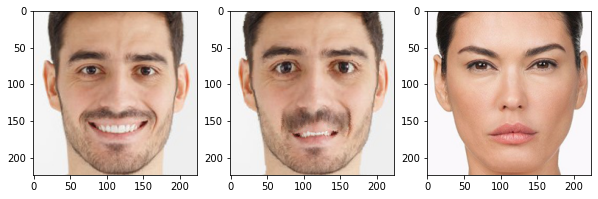

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
out2 = morph(im1, im2, im1_pts, im2_pts, tri.simplices, 0, 1)
axes[0].imshow(im1)
axes[1].imshow(out2)
axes[2].imshow(im2)


In [100]:
images = []
for i in range(30):
  new_img = morph(im1, im2, im1_pts, im2_pts, tri.simplices, i/30.0, i/30.0)
  new_img = Image.fromarray(new_img)
  images.append(new_img)

In [101]:
I = [image1]
I[0].save('/content/drive/My Drive/morphing3.gif',
               save_all=True, append_images=images, optimize=False, duration=50, loop=0)


In [7]:
import os
repo = "CartoonGan-tensorflow"
!git clone https://github.com/mnicnc404/{repo}.git
os.chdir(os.path.join(repo))

Cloning into 'CartoonGan-tensorflow'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1584 (delta 3), reused 5 (delta 2), pack-reused 1577
Receiving objects: 100% (1584/1584), 345.93 MiB | 35.82 MiB/s, done.
Resolving deltas: 100% (688/688), done.
Checking out files: 100% (425/425), done.


In [8]:
#%cd CartoonGan-tensorflow
!ls

cartoonize.py		   inference_with_ckpt.py	  README.md
discriminator.py	   inference_with_saved_model.py  requirements_cpu.txt
environment_linux_cpu.yml  input_images			  requirements_gpu.txt
environment_linux_gpu.yml  layers.py			  scripts
environment_mac_cpu.yml    LICENSE			  style_transfer
exported_models		   light_paprika_ckpt		  to_pb.py
export.py		   light_shinkai_ckpt		  train.py
generator.py		   logger.py
images			   output_images


In [9]:
!pip install tensorflow
#clear_output()

     |████████████████████████████████| 320.4MB 50kB/s 


In [10]:
from IPython.display import clear_output, display, Image

In [11]:
!pip install tensorflow-gpu==2.0.0-alpha0
!git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install
clear_output()

In [12]:
import tensorflow as tf
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

'2.3.1'

In [13]:
input_d= data_dir + '/ori_images'
output_d= data_dir +'/cartoon_images'

In [14]:
styles = "shinkai" #@param ["shinkai", "hayao", "hosoda", "paprika"]

In [15]:
%%capture
!python cartoonize.py \
    --input_dir '/content/drive/My Drive/445_final_proj/face_detection/ori_images' \
    --output_dir '/content/drive/My Drive/445_final_proj/face_detection/cartoon_images'\
    --styles "hayao"\
    --keep_original_size 

In [17]:
from PIL import Image
im1_c = np.array(Image.open('/content/drive/My Drive/445_final_proj/face_detection/cartoon_images/hayao/man1.jpg').resize((224, 224)))
im2_c = np.array(Image.open('/content/drive/My Drive/445_final_proj/face_detection/cartoon_images/hayao/woman3.jpg').resize((224, 224)))
# image = Image.open('shutterstock_149962697-946x658.jpg').convert('L')


In [43]:
images = []
for i in range(30):
  new_img = morph(im2, im2_c, im2_pts, im2_pts, tri.simplices, (29.0-i)/29.0, (29.0-i)/29.0)
  new_img = Image.fromarray(new_img)
  images.append(new_img)
for i in range(30):
  new_img = morph(im2_c, im1_c, im2_pts, im1_pts, tri.simplices, (29.0-i)/29.0, (29.0-i)/29.0)
  new_img = Image.fromarray(new_img)
  images.append(new_img) 
for i in range(30):
  new_img = morph(im1_c, im1, im1_pts, im1_pts, tri.simplices, (29.0-i)/29.0, (29.0-i)/29.0)
  new_img = Image.fromarray(new_img)
  images.append(new_img)  
# for i in range(10):
#   new_img = morph(im2, im1, im2_pts, im2_pts, tri.simplices, (29.0-i)/29.0, (29.0-i)/29.0)
#   new_img = Image.fromarray(new_img)
#   images.append(new_img)      

In [44]:
I = [image1]
I[0].save('/content/drive/My Drive/morphing4.gif',
               save_all=True, append_images=images, optimize=False, duration=50, loop=0)


In [ ]:
im1_c.shape

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(im1_c)
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(im2_c)
plt.axis('off')
plt.show()

In [ ]:
np.array(or1).shape